In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from scipy import linalg
from tqdm import tqdm

# Dataset

In [2]:
#@title Data downloading
large_data = True
if large_data:
  !wget https://files.grouplens.org/datasets/movielens/ml-25m.zip
  !unzip ml-25m.zip
  path = "ml-25m/"
else:
  !wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
  !unzip ml-latest-small.zip
  path = "ml-latest-small/"

--2024-05-18 19:20:23--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  17.0MB/s    in 16s     

2024-05-18 19:20:41 (15.3 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]

Archive:  ml-25m.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       


In [ ]:
large_data = True
if large_data:
    path = "ml-25m/"
else:
    path = "ml-latest-small/"

In [3]:
#@title Data loading
movies = pd.read_csv(path + "movies.csv")
ratings = pd.read_csv(path + "ratings.csv")

## Data Indexing

In [4]:
ratings = ratings.values

In [5]:
M = len(np.unique(ratings[:,0]))
N = len(np.unique(ratings[:,1]))

In [6]:
#@title Indexing the whole dataset
movie_to_id = {}#dictionary
id_to_movie = []
user_to_id = {}#dictionary
id_to_user = []
data_by_user = []
data_by_movie = []

for i in tqdm(range(ratings.shape[0])):
  u_id = ratings[i,0]
  #check if u_id is already in user_to_id
  if not u_id in user_to_id.keys():
    user_to_id[u_id] = len(user_to_id)
    id_to_user.append(u_id)
  #get the movieId watched by user
  m_id =  ratings[i,1]
  #check if movieId (watched by user) is already in movie_to_id
  if not m_id in movie_to_id.keys():
    movie_to_id[m_id] = len(movie_to_id)
    id_to_movie.append(m_id)
  ###########################################
  #add (movieId_new_id, rating) in the dict
  try:
    data_by_user[user_to_id[u_id]].append((movie_to_id[m_id], ratings[i,2]))
  except:
    data_by_user.append([(movie_to_id[m_id], ratings[i,2])])
  ##########################################
  #add (user_new_id, rating) in the dict
  try:
    data_by_movie[movie_to_id[m_id]].append((user_to_id[u_id], ratings[i,2]))
  except:
    data_by_movie.append([(user_to_id[u_id], ratings[i,2])])


# M = len(user_to_id)
# N = len(movie_to_id)

#Number of ratings per users for the training set
number_of_ratings_per_users = [int(0.8*len(l)) for l in data_by_user]

100%|██████████| 25000095/25000095 [01:41<00:00, 246462.56it/s]


In [7]:
#@title Features
#Feature per movies
genres = sorted(list(set('|'.join(list(movies["genres"])).split("|"))))#Get every genre in a list
#Attribute a number to each movie
dict_genres = dict(zip(genres, list(range(20))))#{'(no genres listed)': 0, 'Action': 1, 'Adventure': 2, 'Ani
#Encode genres per movie
features_per_movies = [[] for _ in range(N)]#a list of lists
for n in tqdm(range(N)):
  #get the features of the movie whose new id is i
  genres_per_movie = list(movies[movies["movieId"] == id_to_movie[n]]["genres"])[0].split("|")
  for g in genres_per_movie:
    # test_data_by_movie[movie_index][2][dict_genres[g]] = 1
    features_per_movies[n].append(dict_genres[g])#[dict_genres[g]] = 1

100%|██████████| 59047/59047 [00:38<00:00, 1525.27it/s]


In [8]:
#@title List of movies per feature
movies_with_feature_i = [[] for _ in range(20)]

#loop over feature
for i in range(20):
  #loop over movies
  for n in range(N):
    if i in features_per_movies[n]:
      movies_with_feature_i[i].append(n)

In [9]:
#@title Data indexing v2.1

# np.random.shuffle(ratings)
#Get number of ratings per user

# movie_to_id = {}
# id_to_movie = []
# user_to_id = {}
# id_to_user = []
train_data_by_user = [[[], []] for _ in range(M)]
train_data_by_movie = [[[], [], [0]*20] for _ in range(N)]#three components, the last reserved to feature embedding vector
#
test_data_by_user = [[[], []] for _ in range(M)]
test_data_by_movie = [[[], [], [0]*20] for _ in range(N)]#three components, the last reserved to feature embedding vector

#
for i in tqdm(range(ratings.shape[0])):
    u_id = ratings[i, 0]
    if u_id not in user_to_id:
      user_to_id[u_id] = len(user_to_id)
      id_to_user.append(u_id)

    m_id = ratings[i, 1]
    if m_id not in movie_to_id:
      movie_to_id[m_id] = len(movie_to_id)
      id_to_movie.append(m_id)

    rating = ratings[i, 2]
    user_index = user_to_id[u_id]
    movie_index = movie_to_id[m_id]

    if len(train_data_by_user[user_to_id[u_id]][0]) < number_of_ratings_per_users[user_to_id[u_id]]:
      train_data_by_user[user_index][0].append(movie_index)
      train_data_by_user[user_index][1].append(rating)
      train_data_by_movie[movie_index][0].append(user_index)
      train_data_by_movie[movie_index][1].append(rating)
    else:
      test_data_by_user[user_index][0].append(movie_index)
      test_data_by_user[user_index][1].append(rating)
      test_data_by_movie[movie_index][0].append(user_index)
      test_data_by_movie[movie_index][1].append(rating)

100%|██████████| 25000095/25000095 [01:48<00:00, 230417.91it/s]


# Training

## Adding features

The loss function with features is given by :

\begin{aligned}
\mathcal{L}(\mathbf{U}, \mathbf{V}, \mathbf{b}^{(u)}, \mathbf{b}^{(i)}, \mathbf{F}) & =
- \frac{\lambda}{2} \sum_{m=1}^{M} \sum_{n \in \Omega(m)} \Big(r_{mn} -
(\mathbf{u}_m^T \mathbf{v}_n + b_m^{(u)} + b_n^{(i)}) \Big)^2 \\
& \qquad - \frac{\tau}{2} \sum_{n=1}^N
\left(\mathbf{v}_n - \frac{1}{\sqrt{F_n}} \sum_{\iota \in \mathrm{features}(n)} \mathbf{f}_{\iota} \right)^T \left(\mathbf{v}_n - \frac{1}{\sqrt{F_n}} \sum_{\iota \in \mathrm{features}(n)} \mathbf{f}_{\iota} \right)
\\
& \qquad - \frac{\tau}{2} \sum_{m=1}^M \mathbf{u}_m^T \mathbf{u}_m
- \frac{\tau}{2} \sum_{\iota=1}^{\mathrm{num} \ \mathrm{feats}} \mathbf{f}_{\iota}^T \mathbf{f}_{\iota} \\
& \qquad - \frac{\tau_{\mathrm{bias}}}{2} \sum_{m=1}^M (b_m^{(u)})^2
- \frac{\tau_{\mathrm{bias}}}{2} \sum_{n=1}^N (b_n^{(i)})^2
\end{aligned}

In [26]:
#@title Loss function
def loss_func(train_data_by_user, user_vec, item_vec, user_biases, item_biases, feature_vec, tau, tau_feat, gamma, lambd):
  residual = 0
  count = 0
  for m in range(len(train_data_by_user)):
    movie_indices = train_data_by_user[m][0]
    r_m = np.array(train_data_by_user[m][1])
    count += len(movie_indices)
    residual += np.sum((r_m - (np.dot(user_vec[m].T, item_vec[movie_indices].T)+user_biases[m]+item_biases[movie_indices]))**2)
  diff_item_feat = 0
  feat_vec1 = np.array([np.sum(feature_vec[features_per_movies[n],:], axis=0)/np.sqrt(len(features_per_movies[n])) for n in range(N)])
  feat_vec2 = np.array([np.sum(feature_vec[features_per_movies[n],:], axis=0) for n in range(N)])
  loss = 0.5*lambd*residual + 0.5*tau*(np.sum(user_vec**2)+np.sum((item_vec - feat_vec1)**2)) + 0.5*tau_feat*np.sum(feat_vec2**2) + 0.5*gamma*(np.sum(user_biases**2)+np.sum(item_biases**2))
  rmse = np.sqrt(residual/count)
  return loss, rmse

In [92]:
#@title Training v2.1

#hyperparameters
K  = 10#60#40
lambd = 1#5#0.1
gamma = 0.01#0.2#0.15
tau = 1#0.2#0.15
tau_feat = 1
num_epoch = 20#20

#Initialization
user_vec = np.random.normal(0, 1/np.sqrt(K), size= (M, K))
user_biases = np.zeros(M)
item_vec = np.random.normal(0, 1/np.sqrt(K), size=(N,K))
item_biases = np.zeros(N)
feature_vec = np.random.normal(0, 1/np.sqrt(K), size=(20,K))
##

##
train_loss_history = []
test_loss_history = []
train_rmse_history = []
test_rmse_history = []

##
for epoch in tqdm(range(num_epoch)):
  #user biases
  for m in range(M):
    movie_indices = train_data_by_user[m][0]
    r_m = np.array(train_data_by_user[m][1])
    numerator = np.sum(r_m - np.dot(user_vec[m].T, item_vec[movie_indices,:].T)-item_biases[movie_indices])
    user_biases[m] = lambd*numerator/(lambd*len(r_m)+gamma)
  #item biases
  for n in range(N):
    user_indices = train_data_by_movie[n][0]
    r_n = np.array(train_data_by_movie[n][1])
    # feature_indices = features_per_movies[n]
    # feature_vec[feature_indices,:]
    numerator = np.sum(r_n -np.dot(user_vec[user_indices,:], item_vec[n].T) -user_biases[user_indices])
    item_biases[n] = lambd*numerator/(lambd*len(r_n)+gamma)

  # #user_vec
  for m in range(M):
    movie_indices = train_data_by_user[m][0]
    r_m = np.array(train_data_by_user[m][1])
    term1 = lambd*np.dot(item_vec[movie_indices].T, item_vec[movie_indices])+tau*np.eye(K,K)
    term2 = r_m - user_biases[m] - item_biases[movie_indices]
    term2 = lambd*np.sum(item_vec[movie_indices]*term2.reshape(-1,1), axis=0)
    user_vec[m] = linalg.solve(term1, term2)

  for n in range(N):
    user_indices = train_data_by_movie[n][0]
    r_n = np.array(train_data_by_movie[n][1])
    term1 = lambd*np.dot(user_vec[user_indices].T, user_vec[user_indices])+tau*np.eye(K,K)
    term2 = r_n - user_biases[user_indices] - item_biases[n]
    term2 = lambd*np.sum(user_vec[user_indices]*term2.reshape(-1,1), axis=0)+tau_feat*np.sum(feature_vec[features_per_movies[n],:], axis=0)/np.sqrt(len(features_per_movies[n]))
    item_vec[n] = linalg.solve(term1, term2)
    #
  for i in range(20):
    denominator = tau_feat + tau* sum([1./np.sqrt(len(features_per_movies[n])) for n in movies_with_feature_i[i]])
    feature_vec[i,:] = tau*np.sum(item_vec[movies_with_feature_i[i],:], axis=0)/denominator
  #Loss
  loss, rmse = loss_func(train_data_by_user, user_vec, item_vec, user_biases, item_biases, feature_vec, tau, tau_feat, gamma, lambd)
  train_loss_history.append(loss.copy())
  train_rmse_history.append(rmse.copy())
  test_loss, test_rmse = loss_func(test_data_by_user, user_vec, item_vec, user_biases, item_biases, feature_vec, tau, tau_feat, gamma, lambd)
  test_loss_history.append(test_loss.copy())
  test_rmse_history.append(test_rmse.copy())

100%|██████████| 20/20 [1:03:33<00:00, 190.69s/it]


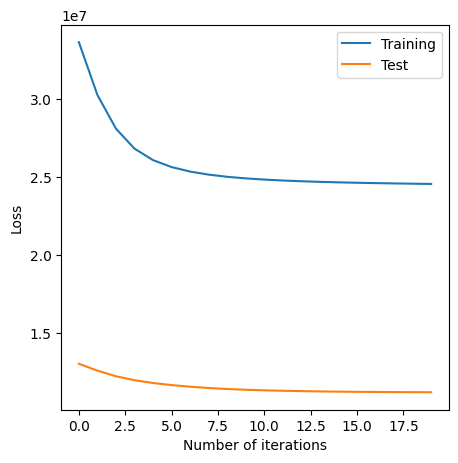

In [93]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(list(range(num_epoch)), train_loss_history, label="Training")
ax.plot(list(range(num_epoch)), test_loss_history, label="Test")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Loss")
ax.legend()
# ax.title("Pos regularized log loss for biases+user and ")
plt.savefig("reg_pos_log_loss_biases_with.pdf", format="pdf", bbox_inches="tight")
plt.show()

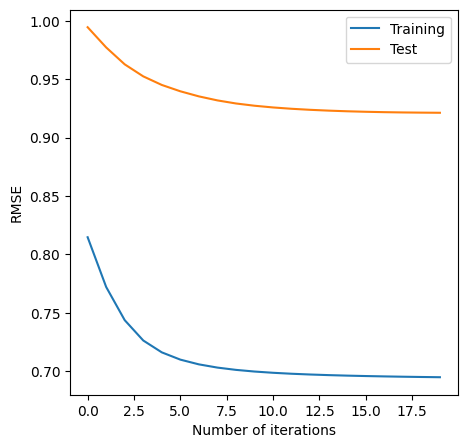

In [94]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(list(range(num_epoch)), train_rmse_history, label="Training")
ax.plot(list(range(num_epoch)), test_rmse_history, label="Test")
ax.set_xlabel("Number of iterations")
ax.set_ylabel("RMSE")
ax.legend()
# ax.title("RMSE for biases+users and items")
plt.savefig("reg_rmse_for_biases_with.pdf", format="pdf", bbox_inches="tight")
# plt.show()

In [95]:
#@title Save my model
# %mkdir model_amls
# %mkdir model_amls/datasets
import pickle

%mkdir /content/model_amls_18_6/

path = "/content/model_amls_18_6/"

with open(path+"params.txt", "w") as file:
    file.write(f"K = {K}\nlambd={lambd}\ngamma={gamma}\ntau={tau}\ntau_feat={tau_feat}\nnum_epoch = {num_epoch}")

with open(path+"user_vec.txt", "wb") as f:
  pickle.dump(user_vec, f)
  print("user_vec saved...")

with open(path+"item_vec.txt", "wb") as f:
  pickle.dump(item_vec, f)
  print("item_vec saved...")

with open(path+"user_biases.txt", "wb") as f:
  pickle.dump(user_biases, f)
  print("user_biases saved...")

with open(path+"item_biases.txt", "wb") as f:
  pickle.dump(item_biases, f)
  print("item_biases saved...")

with open(path+"train_loss_history.txt", "wb") as f:
  pickle.dump(train_loss_history, f)
  print("train_loss_history saved...")

with open(path+"test_loss_history.txt", "wb") as f:
  pickle.dump(test_loss_history, f)
  print("test_loss_history saved...")

with open(path+"train_rmse_history.txt", "wb") as f:
  pickle.dump(train_rmse_history, f)
  print("train_rmse_history saved...")

with open(path+"test_rmse_history.txt", "wb") as f:
  pickle.dump(test_rmse_history, f)
  print("test_rmse_history saved...")

with open(path+"feature_vec.txt", "wb") as f:
  pickle.dump(feature_vec, f)
  print("feature_vec saved...")

!zip -r /content/model_amls_18_6.zip /content/model_amls_18_6/

print("done...")

user_vec saved...
item_vec saved...
user_biases saved...
item_biases saved...
train_loss_history saved...
test_loss_history saved...
train_rmse_history saved...
test_rmse_history saved...
feature_vec saved...
  adding: content/model_amls_18_6/ (stored 0%)
  adding: content/model_amls_18_6/item_vec.txt (deflated 30%)
  adding: content/model_amls_18_6/feature_vec.txt (deflated 2%)
  adding: content/model_amls_18_6/user_biases.txt (deflated 7%)
  adding: content/model_amls_18_6/item_biases.txt (deflated 37%)
  adding: content/model_amls_18_6/train_loss_history.txt (deflated 43%)
  adding: content/model_amls_18_6/test_rmse_history.txt (deflated 43%)
  adding: content/model_amls_18_6/train_rmse_history.txt (deflated 43%)
  adding: content/model_amls_18_6/test_loss_history.txt (deflated 43%)
  adding: content/model_amls_18_6/user_vec.txt (deflated 4%)
  adding: content/model_amls_18_6/params.txt (deflated 7%)
done...


In [96]:
from google.colab import files
files.download(path[:-1]+".zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Prediction

In [13]:
#@title Load model

import pickle

!unzip /content/model_amls_18_3.zip

path = "/content/model_amls_18_3/"

with open(path+"user_vec.txt", "rb") as f:
  user_vec = pickle.load(f)

with open(path+"item_vec.txt", "rb") as f:
  item_vec = pickle.load(f)

with open(path+"user_biases.txt", "rb") as f:
  user_biases = pickle.load(f)

with open(path+"item_biases.txt", "rb") as f:
  item_biases = pickle.load(f)

with open(path+"item_biases.txt", "rb") as f:
  item_biases = pickle.load(f)

Archive:  /content/model_amls_18_3.zip
replace model_amls_18_3/params.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


In [35]:
#Get all movie rated more than 20 times
movie_rated_more_than_20 = [n for n in range(N) if len(data_by_movie[n])>20]

In [36]:
#Sort list and return indixes
def sort_with_indices(lst):
  indexed_lst = list(enumerate(lst))
  indexed_lst.sort(key=lambda x: x[1], reverse=True)  # Sort based on the elements (x[1])
  sorted_indices = [x[0] for x in indexed_lst]  # Extract the sorted indices
  return sorted_indices

In [101]:
 #@title Dummpy user
K = 10
K = 10
lambd=10
gamma=0.4
tau=0.2
tau_feat=0.1
#get a movie id#4896
movie_id = 122892
rate = 5
# print()

print(f"You rate this movie : {movies.iloc[np.where(movies['movieId'].values == movie_id)[0][0]].title}")
#train a dummpy user
new_user = np.zeros(K)
r_m = np.array([rate])
movie_indices = [movie_to_id[movie_id]]
num_epoch = 20
for epoch in range(num_epoch):
  # numerator = np.sum(r_m - np.dot(new_user, item_vec[movie_indices,:].T)-item_biases[movie_indices])
  # user_biases = lambd*numerator/(lambd*len(r_m)+gamma)
  term1 = lambd*np.dot(item_vec[movie_indices].T, item_vec[movie_indices])+tau*np.eye(K,K)
  term2 = r_m - item_biases[movie_indices]
  term2 = lambd*np.sum(item_vec[movie_indices]*term2.reshape(-1,1), axis=0)
  new_user = linalg.solve(term1, term2)

#Make Recommendation
#Compute the cost
score_for_item = np.array([np.dot(new_user, item_vec[n])+item_biases[n] for n in range(N)])
#Compute some recommendations
recommendation_idx = np.where(score_for_item >= 4.5)[0]
#Get movie recommended id
recommendations = [np.where(movies["movieId"].values == id_to_movie[idx])[0][0] for idx in recommendation_idx[:20] ]
movies.iloc[recommendations]

You rate this movie : Avengers: Age of Ultron (2015)


,movieId,title,genres
17067,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX
19678,102125,Iron Man 3 (2013),Action|Sci-Fi|Thriller|IMAX
20513,106072,Thor: The Dark World (2013),Action|Adventure|Fantasy|IMAX
21348,110102,Captain America: The Winter Soldier (2014),Action|Adventure|Sci-Fi|IMAX
25058,122892,Avengers: Age of Ultron (2015),Action|Adventure|Sci-Fi
25067,122912,Avengers: Infinity War - Part I (2018),Action|Adventure|Sci-Fi
25068,122914,Avengers: Infinity War - Part II (2019),Action|Adventure|Sci-Fi
25071,122920,Captain America: Civil War (2016),Action|Sci-Fi|Thriller
44450,168252,Logan (2017),Action|Sci-Fi
35693,148426,Fateful Findings (2013),Drama|Fantasy|Thriller


# Feature embeddings

In [ ]:
frequence_features= [len(movies_with_feature_i[i]) for i in range(20)]
#get three feature with highest size
# idx = sort_with_indices(frequence_features)[:3]

In [ ]:
idx = [dict_genres[g] for g in ["Children", "Horror"]]

In [ ]:
i = idx[1]
for i in idx:
  projected_item_vec = pca.fit_transform(item_vec[movies_with_feature_i[i][:200],:])

  #normalization of PC
  XX = projected_item_vec[:,[0,1]]
  x_mean = XX.mean(axis=0)
  x_max = XX.max(axis=0)
  x_min = XX.min(axis=0)
  XX = (XX - x_mean)/(x_max - x_min)
  plt.scatter(XX[:,0], XX[:,1], alpha=0.8, label=f"{genres[i]}")
  # plt.text(X[i, 0]+0.01, X[i, 1]+0.001, f"{genres[i]}", fontsize=6)
plt.legend()

# Feature embeddings with $K=2$

In [49]:
#@title Training v2.1

#hyperparameters
K  = 2#60#40
lambd = 5#5#0.1
gamma = 0.4#0.2#0.15
tau = 0.2#0.2#0.15
tau_feat = 0.1
num_epoch = 10#20

#Initialization
user_vec = np.random.normal(0, 1/np.sqrt(K), size= (M, K))
user_biases = np.zeros(M)
item_vec = np.random.normal(0, 1/np.sqrt(K), size=(N,K))
item_biases = np.zeros(N)
feature_vec = np.random.normal(0, 1/np.sqrt(K), size=(20,K))
##

##
train_loss_history = []
test_loss_history = []
train_rmse_history = []
test_rmse_history = []

##
for epoch in tqdm(range(num_epoch)):
  #user biases
  for m in range(M):
    movie_indices = train_data_by_user[m][0]
    r_m = np.array(train_data_by_user[m][1])
    numerator = np.sum(r_m - np.dot(user_vec[m].T, item_vec[movie_indices,:].T)-item_biases[movie_indices])
    user_biases[m] = lambd*numerator/(lambd*len(r_m)+gamma)
  #item biases
  for n in range(N):
    user_indices = train_data_by_movie[n][0]
    r_n = np.array(train_data_by_movie[n][1])
    # feature_indices = features_per_movies[n]
    # feature_vec[feature_indices,:]
    numerator = np.sum(r_n -np.dot(user_vec[user_indices,:], item_vec[n].T) -user_biases[user_indices])
    item_biases[n] = lambd*numerator/(lambd*len(r_n)+gamma)

  # #user_vec
  for m in range(M):
    movie_indices = train_data_by_user[m][0]
    r_m = np.array(train_data_by_user[m][1])
    term1 = lambd*np.dot(item_vec[movie_indices].T, item_vec[movie_indices])+tau*np.eye(K,K)
    term2 = r_m - user_biases[m] - item_biases[movie_indices]
    term2 = lambd*np.sum(item_vec[movie_indices]*term2.reshape(-1,1), axis=0)
    user_vec[m] = linalg.solve(term1, term2)

  for n in range(N):
    user_indices = train_data_by_movie[n][0]
    r_n = np.array(train_data_by_movie[n][1])
    term1 = lambd*np.dot(user_vec[user_indices].T, user_vec[user_indices])+tau*np.eye(K,K)
    term2 = r_n - user_biases[user_indices] - item_biases[n]
    term2 = lambd*np.sum(user_vec[user_indices]*term2.reshape(-1,1), axis=0)+tau_feat*np.sum(feature_vec[features_per_movies[n],:], axis=0)/np.sqrt(len(features_per_movies[n]))
    item_vec[n] = linalg.solve(term1, term2)
    #
  for i in range(20):
    denominator = tau_feat + tau* sum([1./np.sqrt(len(features_per_movies[n])) for n in movies_with_feature_i[i]])
    feature_vec[i,:] = tau*np.sum(item_vec[movies_with_feature_i[i],:], axis=0)/denominator
  #Loss
  loss, rmse = loss_func(train_data_by_user, user_vec, item_vec, user_biases, item_biases, feature_vec, tau, tau_feat, gamma, lambd)
  train_loss_history.append(loss.copy())
  train_rmse_history.append(rmse.copy())
  test_loss, test_rmse = loss_func(test_data_by_user, user_vec, item_vec, user_biases, item_biases, feature_vec, tau, tau_feat, gamma, lambd)
  test_loss_history.append(test_loss.copy())
  test_rmse_history.append(test_rmse.copy())

100%|██████████| 10/10 [20:55<00:00, 125.56s/it]


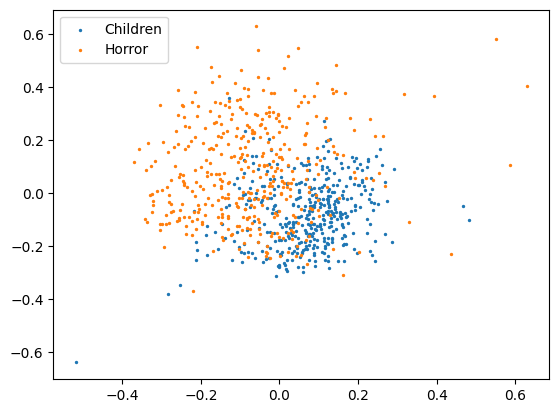

In [89]:

#Indices of movies with genres Children
# movies_with_feature_i[dict_genres["Children"]][:10]
for feature in ["Children", "Horror"]:
  #Movies with feature feature
  feature_movies = item_vec[movies_with_feature_i[dict_genres[feature]][:400],:]
  #Normalize data
  feature_movies = (feature_movies - feature_movies.mean())/(feature_movies.max(axis=0) - feature_movies.min(axis=0))
  plt.scatter(feature_movies[:,0], feature_movies[:,1], s=2, label=feature)
plt.legend()
plt.savefig("feature_embeddings.pdf", format="pdf", bbox_inches="tight")